In [ ]:
1.练习测试的网络为两层的全连接神经网络，共278个输入，第一层100个神经元，第二层十个神经元。
采用了softmax激活函数和梯度下降法进性参数的更新。
2.代码中调用的为梯度下降的api,用上次迭代的参数数值减去学习率乘以交叉熵损失的数值。
3.计算图仅仅是提供了数值计算的流程，没有数值参与运算。只有生成session后导入数值初始化后才有真正的数值计算。
4。准确率低的原因，层数少？

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)

In [5]:
mnist = input_data.read_data_sets('./')
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print(mnist.validation.images.shape)
print(mnist.validation.images.shape)

print(mnist.test.images.shape)
print(mnist.test.images.shape)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000,)
(5000, 784)
(5000, 784)
(10000, 784)
(10000, 784)


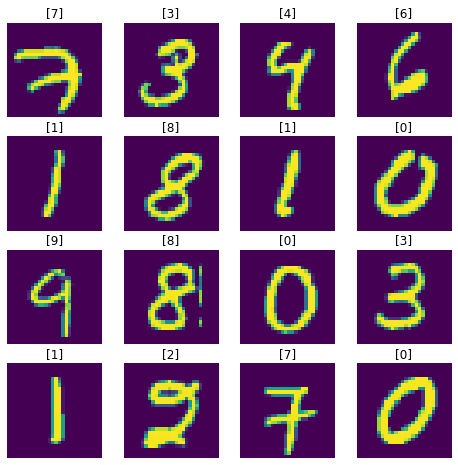

In [6]:
'''将784个数据（像素？）的1维向量转化为28*28的二维向量。
读取数据的标签，其实就是图片的标题。
'''
plt.figure(figsize=(8,8))

for idx in range(16):
    plt.subplot(4,4,idx+1)
    plt.axis('off')
    plt.title('[{}]'.format(mnist.train.labels[idx]))
    plt.imshow(mnist.train.images[idx].reshape((28,28)))

In [13]:
'''定义网络的输入
   以及两层全连接的网络
'''
x = tf.placeholder('float',[None,784])
y = tf.placeholder('int64',[None])
learning_rate = tf.placeholder('float')

def initialize(shape,stddev=0.1):
    '''对数值进行正依太分布数值的初始化
       truncated_normal就是该API
    '''
    return tf.truncated_normal(shape,stddev=0.1)

L1_units_count =100
W_1 = tf.Variable(initialize([784,L1_units_count]))
b_1 = tf.Variable(initialize([L1_units_count]))
logits_1 = tf.matmul(x,W_1) + b_1
output_1 = tf.nn.relu(logits_1)

L2_units_counts = 10
W_2 = tf.Variable(initialize([L1_units_count,L2_units_counts]))
b_2 = tf.Variable(initialize([L2_units_counts]))
logits_2 = tf.matmul(output_1,W_2) + b_2 #此处未进行输出的激活，留作下一步调用softmax和交叉熵的API

logits = logits_2

In [14]:
'''优化器的设置'''
cross_entropy_loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = y))
optimizer = tf.train.GradientDescentOptimizer(
    learning_rate = learning_rate).minimize(cross_entropy_loss)

In [15]:
pred = tf.nn.softmax(logits) #对第二层的输出进行softmax激活

In [16]:
correct_pred = tf.equal(tf.argmax(pred,1),y)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [17]:
batch_size = 32
training_step = 3000

saver = tf.train.Saver()
#至此为止，计算图全部构建完毕

In [22]:
#创建session进行实例化的训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #定义验证集
    validate_data = {
        x:mnist.validation.images,
        y:mnist.validation.labels,
    }
    #测试集
    test_data = {x:mnist.test.images,y:mnist.test.labels}
    
    for i in range(training_step):
        xs,ys = mnist.train.next_batch(batch_size)
        _,loss = sess.run([optimizer,cross_entropy_loss],feed_dict={x:xs,y:ys,learning_rate:0.3})
        
        if i > 0 and i%100 == 0:
            validate_accuracy = sess.run(accuracy,feed_dict=validate_data)
            print('after %d traing steps,the loss is %f'%(i,loss))
            print("The validation accuracy is %f"%validate_accuracy)
            saver.save(sess,'./model.ckpt',global_step=i)
            
    print('the training is finish!')
    #测试集的准确率
    acc = sess.run(accuracy,feed_dict= test_data)
    print('the test accuracy is:',acc)

after 100 traing steps,the loss is 0.542346
The validation accuracy is 0.857400
after 200 traing steps,the loss is 0.308978
The validation accuracy is 0.901600
after 300 traing steps,the loss is 0.311151
The validation accuracy is 0.893200
after 400 traing steps,the loss is 0.403186
The validation accuracy is 0.933800
after 500 traing steps,the loss is 0.059740
The validation accuracy is 0.938400
after 600 traing steps,the loss is 0.647888
The validation accuracy is 0.931400
after 700 traing steps,the loss is 0.167690
The validation accuracy is 0.945200
after 800 traing steps,the loss is 0.280633
The validation accuracy is 0.954400
after 900 traing steps,the loss is 0.163821
The validation accuracy is 0.953800
after 1000 traing steps,the loss is 0.289288
The validation accuracy is 0.953600
after 1100 traing steps,the loss is 0.260141
The validation accuracy is 0.954200
after 1200 traing steps,the loss is 0.197481
The validation accuracy is 0.955400
after 1300 traing steps,the loss is 0

INFO:tensorflow:Restoring parameters from ./model.ckpt-2900
1.0


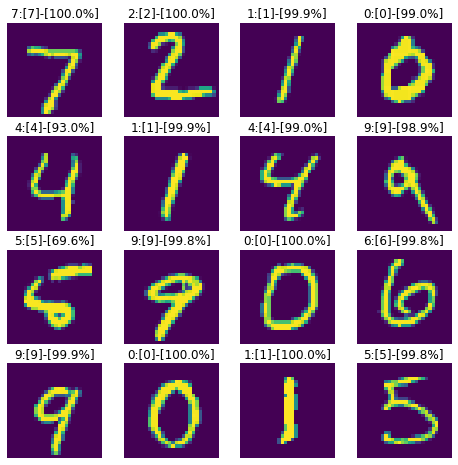

In [27]:
###测试举例
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('./')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess,ckpt.model_checkpoint_path)
        final_pred,acc = sess.run(
            [pred,accuracy],
            feed_dict={
                x:mnist.test.images[:16],
                y:mnist.test.labels[:16],
            })
        orders = np.argsort(final_pred)
        plt.figure(figsize=(8,8))
        print(acc)
        for idx in range(16):
            order = orders[idx,:][-1]
            prob = final_pred[idx,:][order]
            plt.subplot(4,4,idx+1)
            plt.axis('off')
            plt.title('{}:[{}]-[{:.1f}%]'.format(mnist.test.labels[idx],order,prob*100))
            plt.imshow(mnist.test.images[idx].reshape((28,28)))
    else:
        pass
            
        